In [1]:
from jax import config
import jax 
import jax.numpy as jnp

### Restricting the usage to the CPU
jax.config.update('jax_default_device', jax.devices('cpu')[0])

# # JAX supports single-precisions numbers by default.For double precision, use:
# # https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html
config.update("jax_enable_x64", True)

## 1. Checking the basis functions:

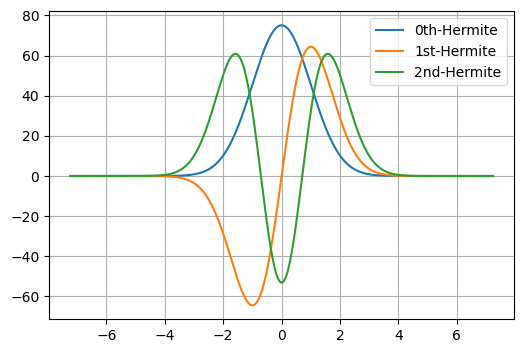

In [2]:
from functions_optimization_real import arb_pulse
import matplotlib.pyplot as plt


avg_phot_num = 10000.0
pulse_coefs0 = jnp.array([jnp.sqrt(avg_phot_num), 0.0, 0.0])
pulse_coefs1 = jnp.array([0.0, jnp.sqrt(avg_phot_num), 0.0])
pulse_coefs2 = jnp.array([0.0, 0.0, jnp.sqrt(avg_phot_num)])

tvar=1
nmax= len(pulse_coefs0) - 1  

#classical turning points plus 5 tvar for safety:
twidth=(jnp.sqrt(2*nmax+1)+5)*tvar 

tarr = jnp.linspace(-twidth,twidth,1000)
ftval0= arb_pulse(tarr, pulse_coefs0, tvar)
ftval1= arb_pulse(tarr, pulse_coefs1, tvar)
ftval2= arb_pulse(tarr, pulse_coefs2, tvar)
##################################################################
fig, (ax1) = plt.subplots(1, 1, figsize=(6,4))

ax1.plot(tarr, ftval0, ls='-', label='0th-Hermite' )
ax1.plot(tarr, ftval1, ls='-', label='1st-Hermite' )
ax1.plot(tarr, ftval2, ls='-', label='2nd-Hermite' )
plt.legend()
plt.grid()


## 2. Optimizing QFI with single seed (LBFGS optimizer~1min for evluation):

In [3]:
import numpy as np
from scipy.interpolate import interp1d
from jax import random
from functions_optimization_real import sing_inst_optimum_lbfgsb

#####################################################################################
### This ensures that the optimal qfi is greater than the optimal qfi of the Gaussian:
data=np.load(f'fisher_optimization_gaussian_-2.0_4.0avgphotons_logspace.npz', 
                mmap_mode='r')
avg_num_phot = data['avg_num_phot']
qfi_vals = data['qfi_vals']

optimal_width_gaussian = interp1d(avg_num_phot, qfi_vals, kind='cubic',
                         fill_value='extrapolate', assume_sorted=True)

####################################################################################
### Paarameters:
avg_num_phot = 1.17
tcap=optimal_width_gaussian(avg_num_phot)
num_basis_funcs=150

### Picking random pulse coefficients between 0.0 and 1.0
key = random.PRNGKey(43911)
ini_seed = random.uniform(
    key, shape=(num_basis_funcs), minval=0.01, maxval=1.0)

### Collecting the results of the optimizer 
(opt_coef, opt_qfi, 
 opt_success)= sing_inst_optimum_lbfgsb(ini_seed, avg_num_phot, tcap)

print("Success:", opt_success)
print("Optimal QFI:",opt_qfi)


Success: 1.0
Optimal QFI: 3.789229444490723


### 2a. Plotting optimal pulse coefficients:

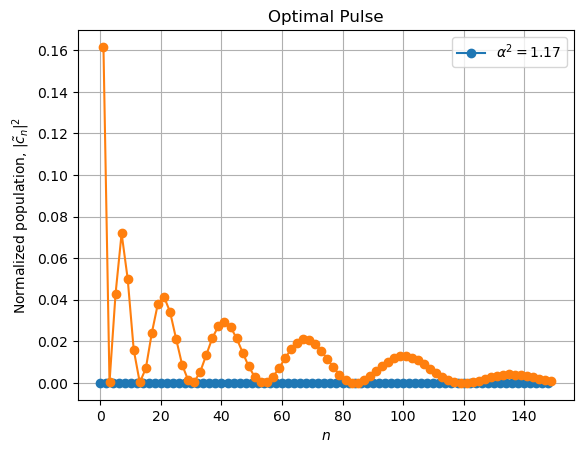

In [4]:
import matplotlib.pyplot as plt

### Plot
narr = jnp.arange(0,num_basis_funcs)
pop = opt_coef**2/avg_num_phot
plt.plot(narr[::2],(1/np.sum(pop))*pop[::2],'o-', label=r'$\alpha^{2} = %g$'% np.round(avg_num_phot,2))
plt.plot(narr[1::2],(1/np.sum(pop))*pop[1::2],'o-')

plt.title("Optimal Pulse")
plt.xlabel(r"$n$")
plt.ylabel(r"Normalized population, $|\tilde{c}_{n}|^{2}$")
plt.legend()
plt.grid()
plt.show()


## 3.  Optimizing QFI with single seed (Adam optimizer ~ 7 mins for evaluation):

In [5]:
from functions_optimization_real import sing_inst_optimum_adam
from jax import random

#####################################################################################
### This ensures that the optimal qfi is greater than the optimal qfi of the Gaussian:
data=np.load(f'fisher_optimization_gaussian_-2.0_4.0avgphotons_logspace.npz', 
                mmap_mode='r')
avg_num_phot = data['avg_num_phot']
qfi_vals = data['qfi_vals']

optimal_width_gaussian = interp1d(avg_num_phot, qfi_vals, kind='cubic',
                         fill_value='extrapolate', assume_sorted=True)

####################################################################################
### Paarameters:
avg_num_phot = 1.17
tcap=optimal_width_gaussian(avg_num_phot)

avg_num_phot = 1.0
num_basis_funcs=150

### Picking random pulse coefficients between 0.0 and 1.0
key = random.PRNGKey(337)
ini_seed = random.uniform(
    key, shape=(num_basis_funcs), minval=0.01, maxval=1.0)

### Collecting the results of the optimizer 
(opt_coef_adam, opt_qfi_adam, 
 opt_success_adam)= sing_inst_optimum_adam(ini_seed, avg_num_phot, tcap)

print("Success:", opt_success_adam)
print("Optimal QFI:",opt_qfi_adam)


Success: 1.0
Optimal QFI: 3.8098790984657747


### 3a. Plotting optimal pulse coefficients:

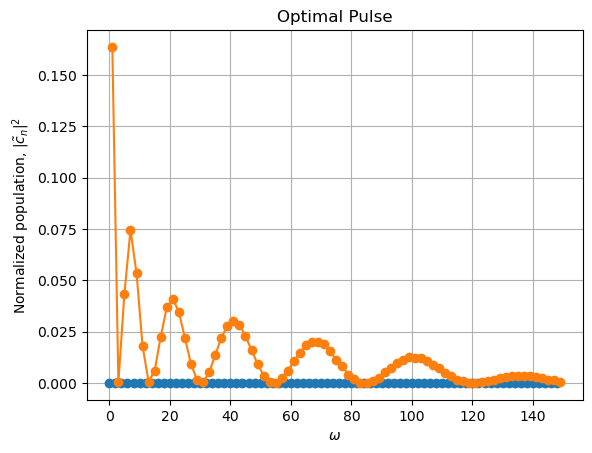

In [6]:
import matplotlib.pyplot as plt

pop = opt_coef_adam**2/avg_num_phot
narr = jnp.arange(0,num_basis_funcs)
### Plot
plt.plot(narr[::2], pop[::2],'o-')
plt.plot(narr[1::2], pop[1::2],'o-')
plt.title("Optimal Pulse")
plt.xlabel(r"$\omega$")
plt.ylabel(r"Normalized population, $|\tilde{c}_{n}|^{2}$")

plt.grid()
plt.show()


## 4. Optimizing over a range of $\alpha^{2}$ with two seeds and LBFGS optimizer (~15 min for evaluation ):

In [7]:

### In this notebook, we use smaller twidth and less number of basis functions
### only for the sake of quick simulations. 

### Parameters:
import numpy as np
import concurrent.futures as cf
from functions_optimization_real import mult_inst_optimum_lbfgsb
from scipy.interpolate import interp1d

### Parameters:
num_basis_funcs = 150
num_rseeds = 2 ## number of random seeds
num_threads = 3 ### Define the number of threads (cores) you want to use

start=-2.0#10.0**-2
end=4.0#10.0**4
avg_num_phot_vec =np.logspace(start, end, 20, endpoint=True)

#####################################################################################
### This ensures that the optimal qfi is greater than the optimal qfi of the Gaussian:
data=np.load(f'fisher_optimization_gaussian_-2.0_4.0avgphotons_logspace.npz', 
                mmap_mode='r')
avg_num_phot = data['avg_num_phot'] 
qfi_vals = data['qfi_vals']

optimal_width_gaussian = interp1d(avg_num_phot, qfi_vals, kind='cubic',
                         fill_value='extrapolate', assume_sorted=True)

tcap_vec=optimal_width_gaussian(avg_num_phot_vec)
####################################################################################
### Storing optimzer solution:
opt_coef_vec = np.zeros([len(avg_num_phot_vec), num_rseeds*num_basis_funcs])
opt_finfo_vec = np.zeros([len(avg_num_phot_vec),num_rseeds])
opt_success_vec = np.zeros([len(avg_num_phot_vec),num_rseeds])

### Performing parallel simulations on three different cores:
with cf.ThreadPoolExecutor(max_workers=num_threads) as executor:
    # Submit the tasks to the executor:
    futures = {executor.submit(mult_inst_optimum_lbfgsb, num_rseeds,
                               avg_num_phot_vec[ind1], num_basis_funcs,
                               tcap_vec[ind1]): ind1
               for ind1 in range(len(avg_num_phot_vec))}
    
    # Wait for all futures to complete and store results in width_vals:
    dummy=0
    for future in cf.as_completed(futures):
        print(dummy, end='\r', flush=True)
        dummy+=1
        ind1 = futures[future]  # Get the index of the result from the dictionary
        (opt_coef_vec[ind1,:],
          opt_finfo_vec[ind1,:],
          opt_success_vec[ind1,:]) = future.result()  # Store the result in the correc
        

### prints true if every optimization is successful:
temp = jnp.any(opt_success_vec == 1, axis=1) #checking if at least one seed succeded
print(jnp.all(temp**1.0 == 1)) # min of one seed success for every alpha


True


### 4a. Plotting optimal QFI:

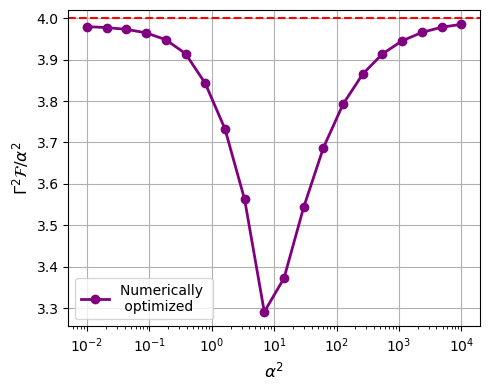

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


fig = plt.figure(figsize=(5.0, 4.0)) 
plt.semilogx(avg_num_phot_vec, np.max(opt_finfo_vec, axis=1),'o-',color='purple', lw=2, label='Numerically \n optimized')
plt.axhline(y=4,ls='--', color='red')

plt.xlabel(r'$\alpha^{2}$', size=12)
plt.ylabel(r'$\Gamma^{2}\mathcal{F}/\alpha^{2}$', size=12)
plt.tick_params(labelsize=10)
plt.grid(True)

# Get the current axes
ax = plt.gca()
# Set minor ticks ONLY on the x-axis (log scale)
ax.xaxis.set_minor_locator(ticker.LogLocator(base=10, subs=range(2, 10), numticks=100))
ax.xaxis.set_minor_formatter(ticker.NullFormatter())  # optional: hide minor labels

plt.tight_layout()
plt.xscale('log')           # make x-axis logarithmic
plt.legend(prop={'size':10},ncol=1)
plt.show()

### 4b. Plotting optimal pulse coefficients:

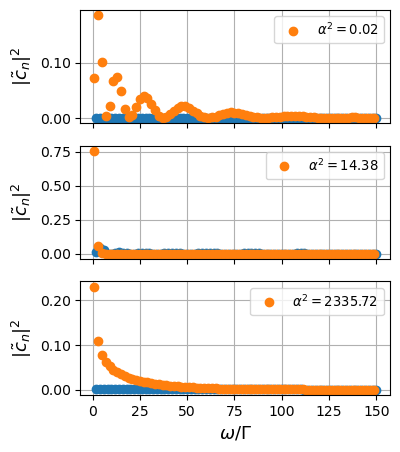

In [9]:
fig, (ax3a, ax3b, ax3c) = plt.subplots(3, 1, sharex=True, figsize=(4, 5))

############################################################################
max_indices = np.argmax(opt_finfo_vec, axis=1)

ind1=1 #
ind2=10
ind3=17
alpha2_1 = avg_num_phot_vec[ind1]
alpha2_2 = avg_num_phot_vec[ind2]
alpha2_3 = avg_num_phot_vec[ind3]
seed_num1 = max_indices[ind1]
seed_num2 = max_indices[ind2]
seed_num3 = max_indices[ind3]

#################################################################################
narr = np.arange(1,num_basis_funcs+1,1)
pop1 = (opt_coef_vec[ind1,seed_num1*num_basis_funcs:(seed_num1+1)*num_basis_funcs])**2
pop2 = (opt_coef_vec[ind2,seed_num2*num_basis_funcs:(seed_num2+1)*num_basis_funcs])**2
pop3 = (opt_coef_vec[ind3,seed_num3*num_basis_funcs:(seed_num3+1)*num_basis_funcs])**2

pop1 = (1/np.sum(pop1))*pop1
pop2 = (1/np.sum(pop2))*pop2
pop3 = (1/np.sum(pop3))*pop3

ax3a.plot(narr[1::2], pop1[1::2],'o')
ax3a.plot(narr[::2], pop1[::2],'o', label=r'$\alpha^{2} = %g$'% np.round((alpha2_1),2))
ax3b.plot(narr[1::2], pop2[1::2],'o')
ax3b.plot(narr[::2], pop2[::2],'o', label=r'$\alpha^{2} = %g$'% np.round((alpha2_2),2))
ax3c.plot(narr[1::2], pop3[1::2],'o')
ax3c.plot(narr[::2], pop3[::2],'o', label=r'$\alpha^{2} = %g$'% np.round((alpha2_3),2))

#################################################################################
ax3a.legend(fontsize=9.5, loc='upper right')
ax3b.legend(fontsize=9.5, loc='upper right')
ax3c.legend(fontsize=9.5, loc='upper right')
ax3a.grid(True)
ax3b.grid(True)
ax3c.grid(True)
ax3a.tick_params('x', labelbottom=False)
ax3b.tick_params('x', labelbottom=False)
ax3c.set_xlabel(r'$\omega/\Gamma$', size=13)
ax3a.set_ylabel(r'$|\tilde{c}_{n}|^{2}$', size=13)
ax3b.set_ylabel(r'$|\tilde{c}_{n}|^{2}$', size=13)
ax3c.set_ylabel(r'$|\tilde{c}_{n}|^{2}$', size=13)

import matplotlib.ticker as ticker
fmt = ticker.FormatStrFormatter('%.2f')   # always show 2 decimals
for ax in (ax3a, ax3b, ax3c):
    ax.yaxis.set_major_formatter(fmt)

plt.show()